In [1]:
using Images

Gray(0.0) # black

In [2]:
RGB(0.0, 0.0, 1.0) # blue

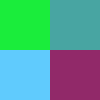

In [3]:
# Images, ImageMagickパッケージを使っている場合、Array{RGB{Float64}}はRGBピクセルを表示する
img_rgb = rand(RGB, 2, 2)

In [4]:
println(img_rgb)

RGB{Float64}[RGB{Float64}(0.10000313095874658,0.9278317451505178,0.23228300203572694) RGB{Float64}(0.2838668672332705,0.6469824930853749,0.6342671207898019); RGB{Float64}(0.3760109349394056,0.7947292306946403,0.9916955559397769) RGB{Float64}(0.5678844927729461,0.16217825386510998,0.4101427704397178)]


## Identiconの生成

参考: [GitHubのIdenticonの生成と取得](https://qiita.com/pira/items/dd4057ef499154968f69#%E3%83%97%E3%83%AD%E3%83%95%E3%82%A3%E3%83%BC%E3%83%AB%E7%94%BB%E5%83%8F%E3%81%AE%E6%88%BB%E3%81%97%E6%96%B9)

### Identiconとは
GitHubアカウントを作成したときにプロフィール画像になってるドット絵アイコン

自分のIdenticonは https://github.com/identicons/<username>.png から確認できる

![amenoyoya.png](https://github.com/identicons/amenoyoya.png)

### Identiconの生成方法
GitHubのBlogにIdenticonの生成に関する記事があるようである

[Identicons!](https://github.com/blog/1586-identicons) - The GitHub Blog

記事によると、Identiconは5x5のピクセルで、ユーザーIDのハッシュ値を元に以下のように生成されているそうである

- ハッシュ値が偶数か奇数かで各ピクセルのon/offを決定してパターンを生成
- Identiconの色も同様にハッシュ値に依存して決定している
    - これによって多数のユニークなIdenticonsを保証している

### Identiconを生成

#### ハッシュ値の生成
ユーザーIDをMD5に変換する

なお、GitHubのユーザ名からユーザIDを取得するには、[Find GitHub User ID](https://caius.github.io/github_id/) を使うと良い

ユーザーIDをMD5に変換すると、128bit（16進数で32桁）のハッシュ値が得られる

ex) 46098475 -> da9701f509fd65331303f9382088b168

#### パターンの決定
パターンは以下のように、5x5のピクセルから成る

ハッシュ値の前から15文字を使って以下のようにパターンを決定する

ハッシュ値が偶数ならピクセルをON，奇数ならピクセルをOFFにする

順番は真ん中の列の上から下、その右の列の上から下、最後に右端の列の上から下の順とする

ex) da9701f509fd65331303f9382088b168 -> da9701f509fd653

以下のように、真ん中の列を中心に線対称に折り返す

これでパターンが完成する

#### 色の決定
ハッシュ値の最後の7文字を使って色を決定する

色はHSL色空間で表現されており、色相3文字、彩度2文字、輝度2文字で決定する

ex) da9701f509fd65331303f9382088b168 -> 088b168 -> 色相: 088, 彩度: b1, 輝度: 68

各16進数を10進数に変換して各パラメータを決定する

色相は0から360の範囲であるため、0(0x000)〜4095(0xfff)を0〜360の範囲に変換する

同様に、彩度と輝度は、0(0x00)〜255(0xff)を0から100の範囲に変換する

GitHubでは0〜255を0〜20の範囲に変換して、それぞれ65, 75から減算した値を使用している

$$ \begin{array}{ll}
    色相: (cbc)_{10} \times \frac{360}{4095} &= 3260 \times \frac{360}{4095} \\
                                             &= 287 \\
    彩度: 65−(db)_{10} \times \frac{20}{255} &= 65−219 \times \frac{20}{255} \\
                                             &= 48 \\
    輝度: 75−(ac)_{10} \times \frac{20}{255} &= 75−172 \times \frac{20}{255}
\end{array} $$

最後にHSL色空間からRGBへ変換し、Identiconの完成となる

In [20]:
# ハッシュ、暗号化ラッパーパッケージNettle利用
using Nettle

# GitHubユーザID
myid = "46098475"

# md5ハッシュ値算出
md5 = hexdigest("md5", myid)

"da9701f509fd65331303f9382088b168"

In [21]:
# ハッシュ値の前から15文字を16進数→10進数に変換
pat = [parse(Int, hash; base=16) for hash in md5[1:15]]

15-element Array{Int64,1}:
 13
 10
  9
  7
  0
  1
 15
  5
  0
  9
 15
 13
  6
  5
  3

In [22]:
# 5 x 3 Array{Int,2} に変形
pat = reshape(pat, 5, 3)

5×3 Array{Int64,2}:
 13   1  15
 10  15  13
  9   5   6
  7   0   5
  0   9   3

In [23]:
# ハッシュ値を偶数・奇数に変換: 0をONとする
pat = pat .% 2

5×3 Array{Int64,2}:
 1  1  1
 0  1  1
 1  1  0
 1  0  1
 0  1  1

In [24]:
# 行列を線対称にする
## 水平結合: pat[3..2列目]のパターン + patのパターン
pat = hcat(pat[:, 3:-1:2], pat)

5×5 Array{Int64,2}:
 1  1  1  1  1
 1  1  0  1  1
 0  1  1  1  0
 1  0  1  0  1
 1  1  0  1  1

In [25]:
"""
色相の算出
"""
# ハッシュ値の後ろから7文字目の部分から3文字分を取得し、16進数→10進数に変換
hue = md5[end-6:end-4]
hue = parse(Int, hue; base=16)

136

In [11]:
# 色相 = (md[-7..-5])_10 * 360 / 4095
hue = hue * 360 / 4095

11.956043956043956

In [12]:
# 彩度 = 65 - (md[-4..-3])_10 * 20 / 255
saturation = 65 - parse(Int, md5[end-3:end-2]; base=16) * 20 / 255

51.11764705882353

In [13]:
# 輝度 = 75 - (md[-2..-1])_10 * 20 / 255
luminance = 75 - parse(Int, md5[end-1:end]; base=16) * 20 / 255

66.84313725490196

In [14]:
# HSV→RGB変換関数
## 色相, 彩度, 輝度 -> (R, G, B)::Tuple{Int,Int,Int}
hsv2rgb(hue::Number, sat::Number, lum::Number)::Tuple{Int,Int,Int} = begin
    max, min = if lum < 50
        # 輝度が50未満の場合
        2.55 * (lum + lum * (sat/100)),
        2.55 * (lum - lum * (sat/100))
    else
        # 輝度が50以上の場合
        2.55 * (lum + (100-lum) * (sat/100)),
        2.55 * (lum - (100-lum) * (sat/100))
    end
    
    # 色相ごとにRGB計算を分岐
    r, g, b = if hue < 60
        max, (hue/60) * (max-min) + min, min
    elseif 60 <= hue < 120
        ((120-hue)/60) * (max-min) + min, max, min
    elseif 120 <= hue < 179
        min, max, ((hue-120)/60) * (max-min) + min
    elseif 180 <= hue < 240
        min, ((240-hue)/60) * (max-min) + min, max
    elseif 240 <= hue < 300
        ((hue-240)/60) * (max-min) + min, min, max
    else
        max, min, ((360-hue)/60) * (max-min) + min
    end
    (Int(floor(r)), Int(floor(g)), Int(floor(b)))
end

hsv2rgb (generic function with 1 method)

In [15]:
color = hsv2rgb(hue, saturation, luminance)

(213, 144, 127)

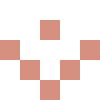

In [26]:
# 作成したパターンのうち、0の部分を着色する
image = zeros(RGB, size(pat)[1], size(pat)[2])

for y in 1:size(pat)[1], x in 1:size(pat)[2]
    image[y, x] = pat[y, x] == 0 ? RGB(color[1]/255, color[2]/255, color[3]/255) : RGB(1.0, 1.0, 1.0)
end

image

In [27]:
"""
完成形
"""

using Nettle
using Images

# idからIdenticon生成
make_identicon(id::String) = begin
    md5 = hexdigest("md5", id)
    pat = [parse(Int, hash; base=16) for hash in md5[1:15]]
    pat = reshape(pat .% 2, 5, 3)
    pat = hcat(pat[:, 3:-1:2], pat)
    hue = parse(Int, md5[end-6:end-4]; base=16) * 360 / 4095
    sat = 65 - parse(Int, md5[end-3:end-2]; base=16) * 20 / 255
    lum = 75 - parse(Int, md5[end-1:end]; base=16) * 20 / 255
    
    max, min = if lum < 50
        2.55 * (lum + lum * (sat/100)),
        2.55 * (lum - lum * (sat/100))
    else
        2.55 * (lum + (100-lum) * (sat/100)),
        2.55 * (lum - (100-lum) * (sat/100))
    end
    
    r, g, b = if hue < 60
        max, (hue/60) * (max-min) + min, min
    elseif 60 <= hue < 120
        ((120-hue)/60) * (max-min) + min, max, min
    elseif 120 <= hue < 179
        min, max, ((hue-120)/60) * (max-min) + min
    elseif 180 <= hue < 240
        min, ((240-hue)/60) * (max-min) + min, max
    elseif 240 <= hue < 300
        ((hue-240)/60) * (max-min) + min, min, max
    else
        max, min, ((360-hue)/60) * (max-min) + min
    end
    
    image = zeros(RGB, size(pat)[1], size(pat)[2])
    for y in 1:size(pat)[1], x in 1:size(pat)[2]
        image[y, x] = pat[y, x] == 0 ? RGB(r/255, g/255, b/255) : RGB(1.0, 1.0, 1.0)
    end
    image
end

make_identicon (generic function with 1 method)

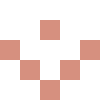

In [28]:
make_identicon("46098475")

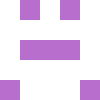

In [29]:
# 参考サイトのユーザID
## 同一の画像が生成されるか確認
make_identicon("19229051")